# Reproduction of fig 8 and 14 and 15 (heatmaps) 

In this notebook we describe how to generate the heatmaps from the paper.

The number of simulations as well as the size of the granules are, by default, set really low in order to reduce the computational time of this notebook. The expected time here is around 5min. It differ from the article where each cell of each heatmaps contains 20 runs for the "unzoom" area with N = 5000 glucose units.

### NB: Fig 15
Fig 15 is all the heatmaps obtained with the strict location model concatenated. To generate a heatmaps using the strict location model, one have to change:

`elif reaction == 'Act_gbe':
    my_granule.Act_gbe_flexible_model()`
    
into:

`elif reaction == 'Act_gbe':
    my_granule.Act_gbe_strict_location()`

### Setting up the parameter grid


Here we generate a single heatmaps as an example. We chose to vary:<br>
$L_{\textrm{min}}^{\textrm{spacing}} \in \{ 1,2,3,4,5,6 \}$ <br>
$L_{\textrm{min}}^{\textrm{transferred}} \in \{ 3 \}$ <br>
$\Gamma \in  \{ 0.1, 0.2, 0.3,0.4,0.6,0.8,1.0,2.0,5.0 \}$<br>


In [14]:
import math
import numpy as np
from pylab import *
import os
import os.path
import json
import glycogen_module as gm
import random
import pandas as pd

random.seed(123)  # add seed for reproducibility


In [15]:
# number of simulations for a given set of parameter:


values_for_spacing = range(1, 7)
values_for_leftover = range(3, 4)

# range for Gamma is obtained by providing given couples (GS, GBE):
values_for_gamma = []
values_for_gys = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1, 1, 1]
values_for_gbe = [1, 1, 1, 1, 1, 1, 1, 0.5, 0.2]

#values_for_gys = [0.4,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.8]
#values_for_gbe = [1,1,1,1,1,1,1,1,1]


for i in range(len(values_for_gbe)):
    values_for_gamma.append(values_for_gys[i]/values_for_gbe[i])


def Gillespie_step(structure, C, k):
    ''' This functions takes concentrations of the enzymes and the structure info of a glycogen granules and
    return what is the next reaction to occurs and which time has been spent. (Following a gillespie algorithm)
    '''
    # propensity assuming mass action kinetics
    h_gs = k["k_GS"]*C["GS"]*len(structure.Find_chain_for_gs())
    h_gp = k["k_GP"]*C["GP"]*len(structure.Find_chain_for_gp())
    h_gbe = k["k_GBE"]*C["GBE"]*len(structure.Find_chain_for_gbe())
    h_gde = k["k_GDE"]*C["GDE"]*len(structure.Find_chain_for_gde())

    a = h_gs + h_gp + h_gbe + h_gde

    if a == 0:
        return "no reaction can be proceed, all propensities are zero", 0
    r2 = random.uniform(0, a)
    r1 = random.uniform(0, 1)

    d_t = (1/a)*math.log(1/r1)
    if r2 < h_gs:
        return "Act_gs", d_t
    elif r2 >= h_gs and r2 < h_gs + h_gp:
        return "Act_gp", d_t
    elif r2 >= h_gs + h_gp and r2 < h_gs + h_gp + h_gbe:
        return "Act_gbe", d_t
    elif r2 >= h_gs + h_gp + h_gbe and r2 < h_gs + h_gp + h_gbe + +h_gde:
        return "Act_gde", d_t

In [16]:
with open("parameters.json", "r") as f:
    parameters = json.load(f)

parameters['b'] = 5.4
parameters['number_of_glucose_to_be_fixed'] = 1000


In [17]:
Number_of_simulations = 5


path_of_local_folder = os.getcwd()
folder_name = '/data_for_heatmaps'
os.mkdir(path_of_local_folder+folder_name)
data_path = path_of_local_folder+folder_name


k = {"k_GS": 1, "k_GBE": 1, "k_GP": 1, "k_GDE": 1}

for leftover in values_for_leftover:
    parameters['size_spec_gbe_leftover'] = leftover
    parameters['size_spec_gbe_transferred'] = leftover
    for spacing in values_for_spacing:
        parameters['size_spec_gbe_spacing'] = spacing
        for gs, gbe in zip(values_for_gys, values_for_gbe):

            identifier = str(spacing)+str(parameters['size_spec_gbe_leftover'])+str(
                parameters['size_spec_gbe_transferred'])+'_'+str(gs/gbe)

            os.mkdir(data_path+'/'+identifier)
            folder_path = data_path+'/'+identifier

            for i in range(Number_of_simulations):
                my_granule = gm.glycogen_structure(parameters, 2, 1)

                N = my_granule.number_of_glucose_fixed()

                # here set GS = 1.0 and GBE = 0.1 if you want to produce the figure for gamma = 10.0
                C0 = {"GS": gs, "GBE": gbe, "GP": 0.00, "GDE": 0.00}

                while N < parameters['number_of_glucose_to_be_fixed']:
                    if N % 5000 == 0:
                        print(
                            'avancement = ', 100*N/parameters['number_of_glucose_to_be_fixed'], '%', '   part 1/2')
                    reaction, time = Gillespie_step(my_granule, C0, k)

                    if reaction == 'Act_gs':
                        my_granule.Act_gs()
                    elif reaction == 'Act_gp' and N > 10:
                        my_granule.Act_gp()
                    elif reaction == 'Act_gbe':
                        my_granule.Act_gbe_flexible_model()
                    elif reaction == 'Act_gde':
                        my_granule.Act_gde()

                    N = my_granule.number_of_glucose_fixed()
                    # print(reaction,time)
                name = 'glycogen_structure'+str(i+1)+'.json'
                my_granule.write_structure(folder_path+'/'+name)


We have now generated the glycogen granules for our parameters grid.

## Best-fit part.


In [18]:
df = pd.read_csv('wt-sullivan.csv')
Y_wt = df['dp'].tolist()
X = np.linspace(0, 40, 41)
path_of_local_folder = os.getcwd()


In [19]:
def cld(dict):
    histo = []
    for chain in dict.values():
        histo.append(len(chain['glucose_location']))
    return histo


def hist_into_curve(distrib: list):
    'this function takes an histogram list and return X and Y arrays to plot the associated curve'

    total = len(distrib)
    maximum = max(distrib)
    # print(maximum)
    X = np.linspace(0, maximum, maximum+1)
    Y = []
    for k in X:
        counter = 0
        for i in range(len(distrib)):
            if k == distrib[i]:
                counter += 1
        Y.append(counter)

    Y = np.asarray(Y)
    return X, Y*1.0/total


def cumulative_cld(path_of_folder: str) -> array:
    cld_cumulated = []

    for i in range(len(os.listdir(path_of_folder))):
        file_name = 'glycogen_structure'+str(i+1)+'.json'
        path = path_of_folder+'/'+file_name

        with open(path, "r") as f:
            my_granule_data = json.load(f)

        distrib = cld(my_granule_data)
        cld_cumulated = cld_cumulated + distrib

    return (cld_cumulated)


def plot_cld_from_distrib(liste):

    bins1 = np.linspace(0, max(liste), max(liste)+1)
    plt.figure(figsize=(14, 7))
    plt.hist(liste, bins=bins1, color='grey', alpha=0.5,
             edgecolor='black', label='packed', density=1)
    plt.xlabel('DP', fontsize=20)
    plt.ylabel('relative abundances', fontsize=20)
    plt.legend()
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.xlim([0, 50])
    plt.show()


In [20]:
folder_name = '/data_for_heatmaps'


In [21]:
curves = []
curves_index = []
likelyhood = []
i = 0
for leftover in values_for_leftover:
    i += 1
    j = 0
    heatmap = np.zeros((len(values_for_spacing), len(values_for_gamma)))

    for spacing in values_for_spacing:
        j += 1
        k = 0

        for gs, gbe in zip(values_for_gys, values_for_gbe):
            k += 1

            identifier = str(spacing)+str(leftover) + \
                str(leftover)+'_'+str(gs/gbe)
            folder_path = path_of_local_folder+folder_name+'/'+identifier

            distrib = cumulative_cld(folder_path)

            DP, Abundance = hist_into_curve(distrib)
            Abundance = list(Abundance)
            while len(Abundance) < 41:
                Abundance.append(0)
            Abundance = Abundance[:len(Y_wt)]
            Abundance = 100*np.asarray(Abundance)
            curves.append(Abundance)
            curves_index.append([leftover, spacing, gs/gbe])

            heatmap[j-1][k-1] = np.sum((Abundance-np.asarray(Y_wt))**2)

    likelyhood.append(heatmap)


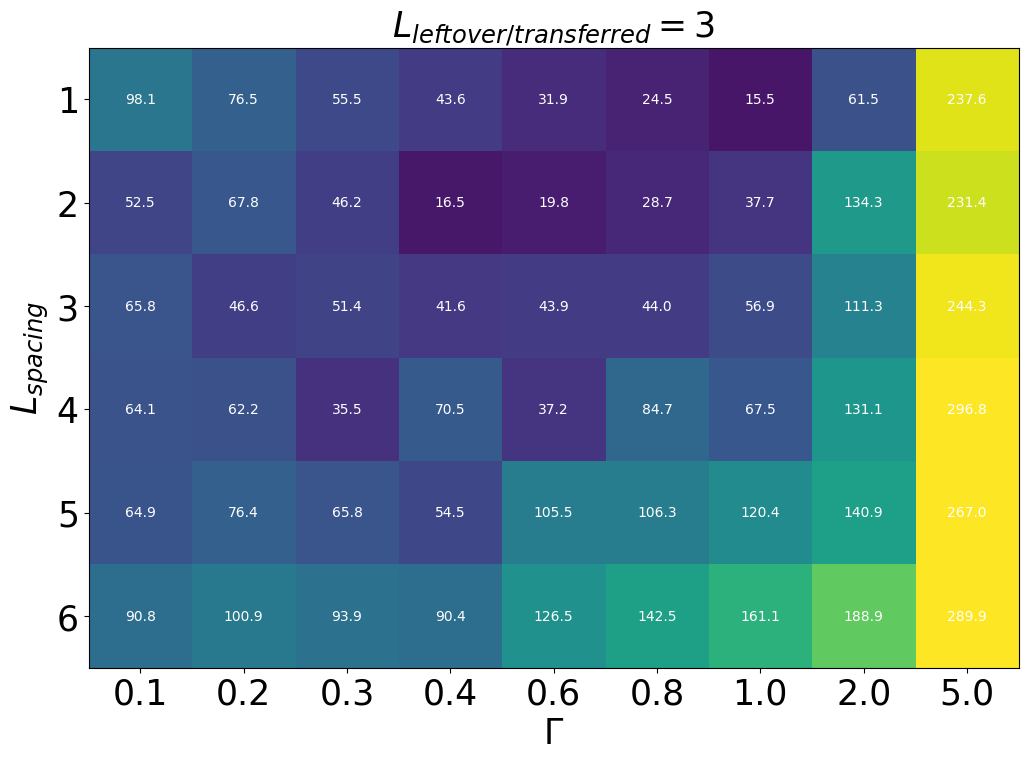

In [25]:
x_ticks = [k for k in range(0, len(values_for_gamma))]
y_ticks = [k for k in range(0, len(values_for_spacing))]

fig, ax1 = plt.subplots(1, 1, figsize=(12, 25))
im1 = ax1.imshow(likelyhood[0])
ax1.set_title(r'$L_{leftover / transferred} = $'+str(leftover), fontsize='25')
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(values_for_gamma, fontsize='25')
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(values_for_spacing, fontsize='25')
# TODO: divider1 = make_axes_locatable(ax1)
#       cax1 = divider1.append_axes("right", size="5%", pad=0.05)
#       cbar1 = plt.colorbar(im1, cax=cax1)
im1.set_clim(0, 250)
ax1.set_xlabel('$\Gamma$', fontsize='25')
ax1.set_ylabel(r'$L_{spacing}$', fontsize='25')
#       cbar1.set_label('fitting score', rotation=270, labelpad=40, fontsize='25')
#       cbar1.ax.tick_params(labelsize=20)

for (j, i), label in np.ndenumerate(likelyhood[0]):
    ax1.text(i, j, round(label, 1), ha='center', va='center', color='white')

plt.savefig('heatmaps_example.png', dpi=350)
